In [1]:
import os
import meshio
import meshplex
import numpy as np
import xarray as xr
import uxarray as uxr
import rioxarray as xrio

from scripts import umeshFcts as ufcts

import matplotlib.pyplot as plt
%matplotlib inline

# Create a mesh from scratch

In cases where one to make some generic models, you could build your input file directly in many ways. 

Here is a simple example where we define a flat elevation at 100 m and a simple tectonic uplift (with a linear slope ranging to 5 mm/yr) and export it to a goSPL input file.

<xarray.Dataset> Size: 6MB
Dimensions:    (x: 501, y: 501)
Coordinates:
  * x          (x) float64 4kB 0.0 200.0 400.0 600.0 ... 9.96e+04 9.98e+04 1e+05
  * y          (y) float64 4kB 0.0 200.0 400.0 600.0 ... 9.96e+04 9.98e+04 1e+05
Data variables:
    elev       (y, x) float64 2MB 99.72 99.15 99.59 99.78 ... 99.76 100.3 100.3
    tec        (y, x) float64 2MB 0.0 1e-05 2e-05 ... 0.00498 0.00499 0.005
    cellwidth  (y, x) float64 2MB 200.0 200.0 200.0 200.0 ... 200.0 200.0 200.0

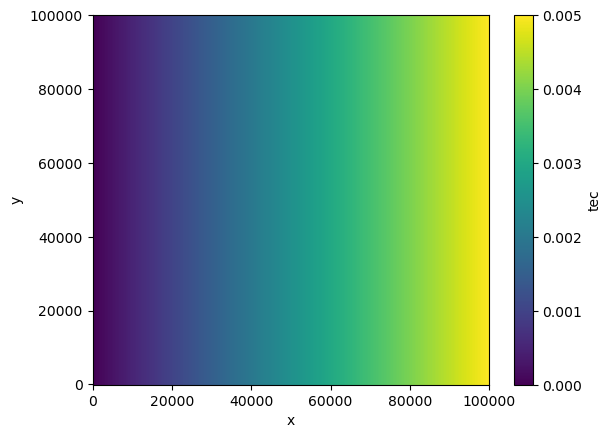

In [3]:
dx = 200 # desired resolution
nx = 501 # desired number of nodes along the x-axis
ny = 501 # desired number of nodes along the y-axis

tmin = 0.
tmax = 0.005

xcoords = np.arange(nx)*float(dx) 
ycoords = np.arange(ny)*float(dx) 
tecx = np.interp(xcoords, [xcoords[0],xcoords[-1]], [tmin,tmax])
tec = np.broadcast_to(tecx, (nx, nx))[:ny,:]


noise = np.random.normal(0, 0.05, tec.shape)
elev = noise+100.

ds = xr.Dataset({
    'elev': xr.DataArray(
                data   = elev,
                dims   = ['y','x'],
                coords = {'x': xcoords,'y': ycoords},
                ),
    'tec': xr.DataArray(
                data   = tec,
                dims   = ['y','x'],
                coords = {'x': xcoords,'y': ycoords},
                )
        }
    )
ds['cellwidth'] = (['y','x'],dx*np.ones( (ny, nx)))
ds.tec.plot()
ds


We then build the unstructured grid for running goSPL

In [31]:
output_path = "slope_tec" 
if not os.path.exists(output_path):
    os.makedirs(output_path)
    
# Build your planar mesh
ufcts.planarMesh(ds,output_path,fvtk='planar.vtk',fumpas=True,voro=True)


Running: jigsaw slope_tec/mesh2D.jig
 
#------------------------------------------------------------
#
#   ,o, ,o,       /                                 
#    `   `  e88~88e  d88~\   /~~~8e Y88b    e    / 
#   888 888 88   88 C888         88b Y88b  d8b  /   
#   888 888 "8b_d8"  Y88b   e88~-888  Y888/Y88b/  
#   888 888  /        888D C88   888   Y8/  Y8/     
#   88P 888 Cb      \_88P   "8b_-888    Y    Y    
# \_8"       Y8""8D                             
#
#------------------------------------------------------------
# JIGSAW: an unstructured mesh generation library.  
#------------------------------------------------------------
 
  JIGSAW VERSION 0.9.14

  Reading CFG. file...

  CFG. data summary...

  GEOM-FILE = slope_tec/mesh2D.msh 
  MESH-FILE = slope_tec/mesh2D-MESH.msh 
  HFUN-FILE = slope_tec/mesh2D-HFUN.msh 
  INIT-FILE =  
  TRIA-FILE =  
  BNDS-FILE =  

  GEOM-SEED = 8 
  GEOM-PHI1 = 6.00e+01 
  GEOM-PHI2 = 6.00e+01 
  GEOM-ETA1 = 4.50e+01 
  GEOM-ETA2 = 4.50e+01 
 

Build time indices:   0% |                                     | ETA:  --:--:--
Build time indices: 100% |#####################################| Time:  0:00:00


maxEdges=
nVertLevels=
nParticles=

Extracting a total of 1 time levels.
Using file 'slope_tec/base2D.nc' as the mesh file for this extraction.


The following variables will be extracted from the input file(s).

   Variables with 'nCells' as a dimension:
      name: areaCell

 -- Extracting cell fields --
Build geometry for fields on cells...


Writing time series:   0% |                                    | ETA:  --:--:--
Writing time series:   0% |                                    | ETA:  --:--:--
Writing time series: 100% |####################################| Time:  0:00:00


The mesh (`base2D.nc`) is now stored in the output folder (here named `slope`). 

We will open this file and extract the information used in goSPL:

In [37]:
# Loading the UGRID file
ufile = output_path+'/base2D.nc'
var_name = 'data'
ugrid = uxr.open_grid(ufile) 

# Perform the interpolation (bilinear) 
ufcts.inter2UGRID(ds[['elev','tec']],ugrid,output_path,var_name,type='face',latlon=False)
# ufcts.inter2UGRID(ds[['t']],ugrid,output_path,var_name,type='face',latlon=False)

data_file = [output_path+'/'+var_name+'.nc']
# Get the information related to the mesh: primal and dual mesh
primal_mesh = uxr.open_dataset(ufile, *data_file, use_dual=False)
dual_mesh = uxr.open_dataset(ufile, *data_file, use_dual=True)

# Extract nodes and faces information
ucoords = np.empty((dual_mesh.uxgrid.n_node,3))
ucoords[:,0] = dual_mesh.uxgrid.node_x.values
ucoords[:,1] = dual_mesh.uxgrid.node_y.values
ucoords[:,2] = dual_mesh.uxgrid.node_z.values
ufaces = primal_mesh.uxgrid.node_face_connectivity.values

# Get information about your mesh:
print("Number of nodes: ",len(ucoords)," | number of faces ",len(ufaces))
edge_min = np.round(dual_mesh.uxgrid.edge_node_distances.min().values/1000.+0.,2)
edge_max = np.round(dual_mesh.uxgrid.edge_node_distances.max().values/1000.+0.,2)
edge_mean = np.round(dual_mesh.uxgrid.edge_node_distances.mean().values/1000.+0.,2)
print("edge range (km): min ",edge_min," | max ",edge_max," | mean ",edge_mean)

Number of nodes:  290033  | number of faces  578064
edge range (km): min  0.05  | max  0.16  | mean  0.12


We now read the created `vtk` file and add the interpolated variables to it:

In [38]:
mesh = meshio.read(output_path+'/planar.vtk')
vertex = mesh.points
cells = mesh.cells_dict['triangle']
Umesh = meshplex.MeshTri(vertex, cells)
Uarea = Umesh.control_volumes
print('Cell area (km2): ',Uarea.min()*1.e-6,Uarea.max()*1.e-6)

# Define mesh
paleovtk = output_path+"/init.vtk"
vis_mesh = meshio.Mesh(vertex, {"triangle": cells}, 
                       point_data={"elev": primal_mesh.elev.values,
                                   "tec": primal_mesh.tec.values,
                                   },
                       )

# Write it disk
meshio.write(paleovtk, vis_mesh)
print("Writing VTK input file as {}".format(paleovtk))

Cell area (km2):  0.007981124848090985 0.04379502688683179
Writing VTK input file as slope_tec/init.vtk


### Creating goSPL input

We will now create the inputs for goSPL. We first start by creating the input mesh defining our UGRID structure:

In [39]:
meshname = output_path+"/gospl_mesh"
np.savez_compressed(meshname, v=vertex, c=cells, 
                    z=primal_mesh.elev.data, t=primal_mesh.tec.data
                    )

# Escarpment input

<xarray.Dataset> Size: 1MB
Dimensions:    (x: 301, y: 301)
Coordinates:
  * x          (x) float64 2kB 0.0 1e+03 2e+03 3e+03 ... 2.98e+05 2.99e+05 3e+05
  * y          (y) float64 2kB 0.0 1e+03 2e+03 3e+03 ... 2.98e+05 2.99e+05 3e+05
Data variables:
    elev       (y, x) float64 725kB 99.93 99.96 100.0 ... 1e+03 1e+03 1e+03
    cellwidth  (y, x) float64 725kB 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03

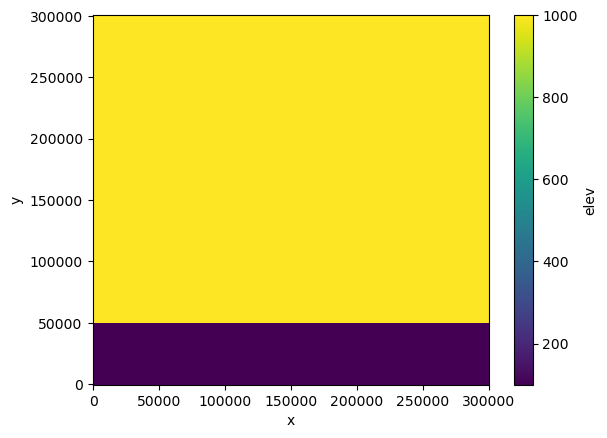

In [30]:
dx = 1000 # desired resolution
nx = 301 # desired number of nodes along the x-axis
ny = 301 # desired number of nodes along the y-axis

# tmin = 0.
# tmax = 0.005

xcoords = np.arange(nx)*float(dx) 
ycoords = np.arange(ny)*float(dx) 
elev = np.interp(xcoords, [xcoords[0],xcoords[-1]], [0,0])
elev = np.broadcast_to(elev, (nx, nx))[:ny,:]


noise = np.random.normal(0, 0.05, elev.shape)
elev = noise+100.
elev[50:,:] += 900 

ds = xr.Dataset({
    'elev': xr.DataArray(
                data   = elev,
                dims   = ['y','x'],
                coords = {'x': xcoords,'y': ycoords},
                ),
    # 'tec': xr.DataArray(
    #             data   = tec,
    #             dims   = ['y','x'],
    #             coords = {'x': xcoords,'y': ycoords},
    #             )
        }
    )
ds['cellwidth'] = (['y','x'],dx*np.ones( (ny, nx)))
ds.elev.plot()
ds


In [31]:
output_path = "escarpment" 
if not os.path.exists(output_path):
    os.makedirs(output_path)
    
# Build your planar mesh
ufcts.planarMesh(ds,output_path,fvtk='planar.vtk',fumpas=True,voro=True)


Running: jigsaw escarpment/mesh2D.jig
 
#------------------------------------------------------------
#
#   ,o, ,o,       /                                 
#    `   `  e88~88e  d88~\   /~~~8e Y88b    e    / 
#   888 888 88   88 C888         88b Y88b  d8b  /   
#   888 888 "8b_d8"  Y88b   e88~-888  Y888/Y88b/  
#   888 888  /        888D C88   888   Y8/  Y8/     
#   88P 888 Cb      \_88P   "8b_-888    Y    Y    
# \_8"       Y8""8D                             
#
#------------------------------------------------------------
# JIGSAW: an unstructured mesh generation library.  
#------------------------------------------------------------
 
  JIGSAW VERSION 0.9.14

  Reading CFG. file...

  CFG. data summary...

  GEOM-FILE = escarpment/mesh2D.msh 
  MESH-FILE = escarpment/mesh2D-MESH.msh 
  HFUN-FILE = escarpment/mesh2D-HFUN.msh 
  INIT-FILE =  
  TRIA-FILE =  
  BNDS-FILE =  

  GEOM-SEED = 8 
  GEOM-PHI1 = 6.00e+01 
  GEOM-PHI2 = 6.00e+01 
  GEOM-ETA1 = 4.50e+01 
  GEOM-ETA2 = 4.50e+0

Build time indices:   0% |                                     | ETA:  --:--:--
Build time indices: 100% |#####################################| Time:  0:00:00


maxEdges=
nVertLevels=
nParticles=

Extracting a total of 1 time levels.
Using file 'escarpment/base2D.nc' as the mesh file for this extraction.


The following variables will be extracted from the input file(s).

   Variables with 'nCells' as a dimension:
      name: areaCell

 -- Extracting cell fields --
Build geometry for fields on cells...


Writing time series:   0% |                                    | ETA:  --:--:--
Writing time series:   0% |                                    | ETA:  --:--:--
Writing time series: 100% |####################################| Time:  0:00:00


In [34]:
# Loading the UGRID file
ufile = output_path+'/base2D.nc'
var_name = 'data'
ugrid = uxr.open_grid(ufile) 

# Perform the interpolation (bilinear) 
ufcts.inter2UGRID(ds[['elev']],ugrid,output_path,var_name,type='face',latlon=False)

data_file = [output_path+'/'+var_name+'.nc']
# Get the information related to the mesh: primal and dual mesh
primal_mesh = uxr.open_dataset(ufile, *data_file, use_dual=False)
dual_mesh = uxr.open_dataset(ufile, *data_file, use_dual=True)

# Extract nodes and faces information
ucoords = np.empty((dual_mesh.uxgrid.n_node,3))
ucoords[:,0] = dual_mesh.uxgrid.node_x.values
ucoords[:,1] = dual_mesh.uxgrid.node_y.values
ucoords[:,2] = dual_mesh.uxgrid.node_z.values
ufaces = primal_mesh.uxgrid.node_face_connectivity.values

# Get information about your mesh:
print("Number of nodes: ",len(ucoords)," | number of faces ",len(ufaces))
edge_min = np.round(dual_mesh.uxgrid.edge_node_distances.min().values/1000.+0.,2)
edge_max = np.round(dual_mesh.uxgrid.edge_node_distances.max().values/1000.+0.,2)
edge_mean = np.round(dual_mesh.uxgrid.edge_node_distances.mean().values/1000.+0.,2)
print("edge range (km): min ",edge_min," | max ",edge_max," | mean ",edge_mean)

Number of nodes:  104449  | number of faces  207696
edge range (km): min  0.26  | max  0.81  | mean  0.58


In [35]:
mesh = meshio.read(output_path+'/planar.vtk')
vertex = mesh.points
cells = mesh.cells_dict['triangle']
Umesh = meshplex.MeshTri(vertex, cells)
Uarea = Umesh.control_volumes
print('Cell area (km2): ',Uarea.min()*1.e-6,Uarea.max()*1.e-6)

# Define mesh
paleovtk = output_path+"/init.vtk"
vis_mesh = meshio.Mesh(vertex, {"triangle": cells}, 
                       point_data={"elev": primal_mesh.elev.values,
                                   },
                       )

# Write it disk
meshio.write(paleovtk, vis_mesh)
print("Writing VTK input file as {}".format(paleovtk))

Cell area (km2):  0.199588270519242 1.082714441326647
Writing VTK input file as escarpment/init.vtk


In [36]:
meshname = output_path+"/escarpment2"
np.savez_compressed(meshname, v=vertex, c=cells, 
                    z=primal_mesh.elev.data
                    )

# Create a mesh from a geotiff dataset

We first demonstrate how to create a goSPL inputs from a given geotiff (equivalently one could use a netCDF grid as a starting file).

### Extracting and clipping elevation from geotiff

In [3]:
output_path = "geotiff" 
if not os.path.exists(output_path):
    os.makedirs(output_path)

xds = xrio.open_rasterio("data/srtm_36_04.tif")
xds

<xarray.DataArray (band: 1, y: 120, x: 300)> Size: 72kB
[36000 values with dtype=int16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB 14.35 14.35 14.35 14.35 ... 14.6 14.6 14.6 14.6
  * y            (y) float64 960B 50.1 50.1 50.1 50.1 ... 50.0 50.0 50.0 50.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

The geotiff contains elevation information in a lon/lat coordinate system:

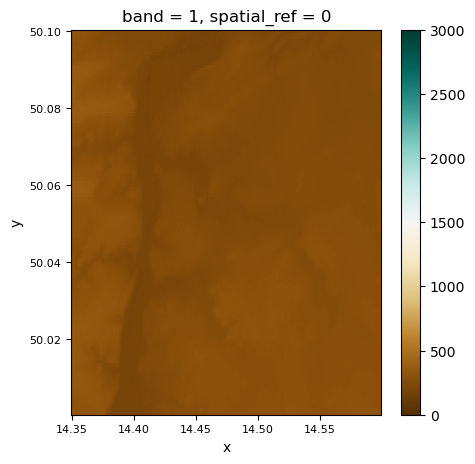

In [4]:
plt.figure(figsize=(5,5))
im = xds.sel(band=1).plot(cmap='BrBG', vmin=-0.5, vmax=3000)
im.figure.axes[0].tick_params(axis="both", labelsize=8)
plt.show()

We first reproject the dataset into a UTM grid:

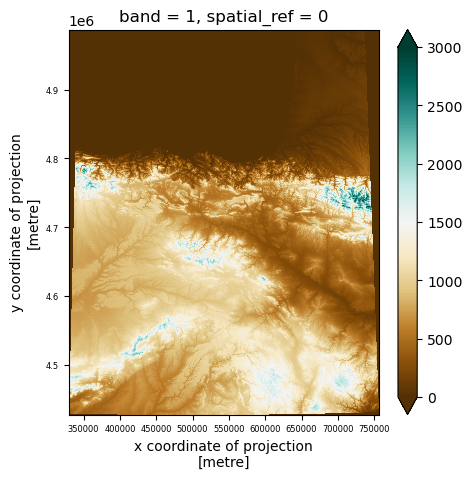

In [4]:
xds_utm = xds.rio.reproject(xds.rio.estimate_utm_crs())
plt.figure(figsize=(5,5))
im = xds_utm.sel(band=1).plot.imshow(cmap='BrBG', vmin=-0.5, vmax=3000)
im.figure.axes[0].tick_params(axis="both", labelsize=6)
plt.show()

We then crop to a region of interest based on UTM coordinates:

In [5]:
# Specify the bounding box
geometries = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [400000, 4.5e6],
            [600000, 4.5e6],
            [600000, 4.75e6],
            [400000, 4.75e6]
        ]]
    }
]

# Clip your region
clipped = xds_utm.rio.clip(geometries)
clipped = clipped.sortby(clipped.x)
clipped = clipped.sortby(clipped.y)
clipped

<xarray.DataArray (band: 1, y: 3073, x: 2458)> Size: 15MB
array([[[1449, 1449, 1448, ..., 1362, 1353, 1352],
        [1446, 1445, 1446, ..., 1374, 1368, 1365],
        [1444, 1446, 1446, ..., 1382, 1379, 1373],
        ...,
        [1038, 1047, 1067, ...,  515,  536,  548],
        [1047, 1062, 1082, ...,  526,  550,  558],
        [1060, 1071, 1106, ...,  541,  572,  576]]], dtype=int16)
Coordinates:
  * x            (x) float64 20kB 4e+05 4.001e+05 4.002e+05 ... 5.999e+05 6e+05
  * y            (y) float64 25kB 4.5e+06 4.5e+06 4.5e+06 ... 4.75e+06 4.75e+06
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -32768

We are now interpolating the data to a specific resolution (here `dx` 500 m):

In [6]:
dx = 500.
newx = np.arange(401000,600000,dx)
newy = np.arange(4501000,4750000,dx)
newds = clipped.interp(x=newx, y=newy, method="cubic")
elev = newds.sel(band=1).copy()
nds = xr.Dataset({
    'elev': xr.DataArray(
                data   = elev,   
                dims   = ['y','x'],
                coords = {'x': newx, 'y': newy},
                ),
})
nds

<xarray.Dataset> Size: 2MB
Dimensions:  (x: 398, y: 498)
Coordinates:
  * x        (x) float64 3kB 4.01e+05 4.015e+05 4.02e+05 ... 5.99e+05 5.995e+05
  * y        (y) float64 4kB 4.501e+06 4.502e+06 ... 4.749e+06 4.75e+06
Data variables:
    elev     (y, x) float64 2MB 1.58e+03 1.581e+03 1.417e+03 ... 626.5 528.5

### Building a UGRID for goSPL

We will now create an unstructured mesh based on `jigsaw` library. 

First we use the same resolution as our interpolated geotiff dataset (`mesh_res` = `dx`)

In [7]:
mesh_res = dx

# Build your planar mesh
shape = nds.elev.shape
nds['cellwidth'] = (['y','x'],mesh_res*np.ones(shape))
ufcts.planarMesh(nds,output_path,fvtk='planar.vtk',fumpas=True,voro=True)

The mesh (`base2D.nc`) is now stored in the output folder (here named `geotiff`). 

We will open this file and extract the information used in goSPL:

In [8]:
# Loading the UGRID file
ufile = output_path+'/base2D.nc'
var_name = 'data'
ugrid = uxr.open_grid(ufile) 

# Perform the interpolation (bilinear) 
ufcts.inter2UGRID(nds[['elev']],ugrid,output_path,var_name,type='face',latlon=False)

data_file = [output_path+'/'+var_name+'.nc']
# Get the information related to the mesh: primal and dual mesh
primal_mesh = uxr.open_dataset(ufile, *data_file, use_dual=False)
dual_mesh = uxr.open_dataset(ufile, *data_file, use_dual=True)

# Extract nodes and faces information
ucoords = np.empty((dual_mesh.uxgrid.n_node,3))
ucoords[:,0] = dual_mesh.uxgrid.node_x.values
ucoords[:,1] = dual_mesh.uxgrid.node_y.values
ucoords[:,2] = dual_mesh.uxgrid.node_z.values
ufaces = primal_mesh.uxgrid.node_face_connectivity.values

# Get information about your mesh:
print("Number of nodes: ",len(ucoords)," | number of faces ",len(ufaces))
edge_min = np.round(dual_mesh.uxgrid.edge_node_distances.min().values/1000.+0.,2)
edge_max = np.round(dual_mesh.uxgrid.edge_node_distances.max().values/1000.+0.,2)
edge_mean = np.round(dual_mesh.uxgrid.edge_node_distances.mean().values/1000.+0.,2)
print("edge range (km): min ",edge_min," | max ",edge_max," | mean ",edge_mean)

Number of nodes:  228573  | number of faces  455356
edge range (km): min  0.12  | max  0.41  | mean  0.29


We now read the created `vtk` file and add the interpolated variables to it:

In [9]:
mesh = meshio.read(output_path+'/planar.vtk')
vertex = mesh.points
cells = mesh.cells_dict['triangle']
Umesh = meshplex.MeshTri(vertex, cells)
Uarea = Umesh.control_volumes
print('Cell area (km2): ',Uarea.min()*1.e-6,Uarea.max()*1.e-6)

# Define mesh
paleovtk = output_path+"/init.vtk"
vis_mesh = meshio.Mesh(vertex, {"triangle": cells}, 
                       point_data={"elev": primal_mesh.elev.values,
                                   },
                       )

# Write it disk
meshio.write(paleovtk, vis_mesh)
print("Writing VTK input file as {}".format(paleovtk))

Cell area (km2):  0.049884420483569905 0.2461726804201905
Writing VTK input file as geotiff/init.vtk


### Creating goSPL input

We will now create the inputs for goSPL. We first start by creating the input mesh defining our UGRID structure:

In [11]:
meshname = output_path+"/gospl_mesh"
np.savez_compressed(meshname, v=vertex, c=cells, 
                    z=primal_mesh.elev.data
                    )

# Making a variable resolution mesh

Following the approach described above one could create a more complex unstructured mesh with variable cell width based on user defined crietria.

Here we illustrate how this could be done by using the elevation to refine the mesh.

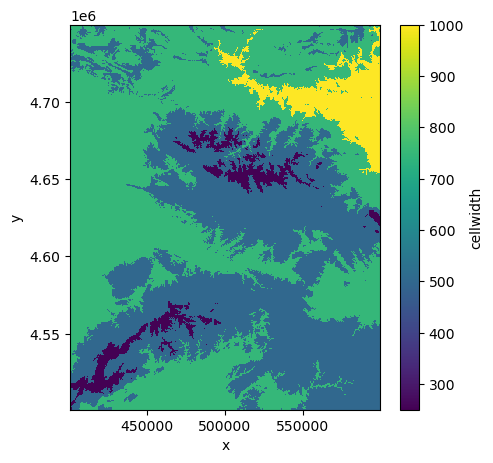

In [26]:
def weightsElev(ds):

    y = ds.y.values
    x = ds.x.values
    val = ds.elev.copy()
    ds['cellwidth'] = ( ['y','x'], 5000*np.ones((y.size, x.size)))
    ds['cellwidth'] = ds['cellwidth'].where((val<-1000)|(val>0),1500)
    ds['cellwidth'] = ds['cellwidth'].where((val<0)|(val>500),1000)
    ds['cellwidth'] = ds['cellwidth'].where((val<500)|(val>1000),750)
    ds['cellwidth'] = ds['cellwidth'].where((val<1000)|(val>1500),500)
    ds['cellwidth'] = ds['cellwidth'].where(val<1500,250)

    return ds

nds = weightsElev(nds)
plt.figure(figsize=(5,5))
nds.cellwidth.plot()
plt.show()

We now use the same command as before but with variable width:

In [27]:
mesh_res = dx
output_path = 'geotiff_refined'
if not os.path.exists(output_path):
    os.makedirs(output_path)
    
# Build your planar mesh using the width specified above
ufcts.planarMesh(nds,output_path,fvtk='planar.vtk',fumpas=True,voro=True)

Running: jigsaw geotiff_refined/mesh2D.jig
 
#------------------------------------------------------------
#
#   ,o, ,o,       /                                 
#    `   `  e88~88e  d88~\   /~~~8e Y88b    e    / 
#   888 888 88   88 C888         88b Y88b  d8b  /   
#   888 888 "8b_d8"  Y88b   e88~-888  Y888/Y88b/  
#   888 888  /        888D C88   888   Y8/  Y8/     
#   88P 888 Cb      \_88P   "8b_-888    Y    Y    
# \_8"       Y8""8D                             
#
#------------------------------------------------------------
# JIGSAW: an unstructured mesh generation library.  
#------------------------------------------------------------
 
  JIGSAW VERSION 0.9.14

  Reading CFG. file...

  CFG. data summary...

  GEOM-FILE = geotiff_refined/mesh2D.msh 
  MESH-FILE = geotiff_refined/mesh2D-MESH.msh 
  HFUN-FILE = geotiff_refined/mesh2D-HFUN.msh 
  INIT-FILE =  
  TRIA-FILE =  
  BNDS-FILE =  

  GEOM-SEED = 8 
  GEOM-PHI1 = 6.00e+01 
  GEOM-PHI2 = 6.00e+01 
  GEOM-ETA1 = 4.50e+01 
 

Build time indices:   0% |                                     | ETA:  --:--:--
Build time indices: 100% |#####################################| Time:  0:00:00


maxEdges=
nVertLevels=
nParticles=

Extracting a total of 1 time levels.
Using file 'geotiff_refined/base2D.nc' as the mesh file for this extraction.


The following variables will be extracted from the input file(s).

   Variables with 'nCells' as a dimension:
      name: areaCell

 -- Extracting cell fields --


Writing time series:   0% |                                    | ETA:  --:--:--


Build geometry for fields on cells...


Writing time series:   0% |                                    | ETA:  --:--:--
Writing time series: 100% |####################################| Time:  0:00:00


Getting the corresponding mesh information:

In [28]:
# Loading the UGRID file
ufile = output_path+'/base2D.nc'
var_name = 'data'
ugrid = uxr.open_grid(ufile) 

# Perform the interpolation (bilinear) 
ufcts.inter2UGRID(nds[['elev']],ugrid,output_path,var_name,type='face',latlon=False)

data_file = [output_path+'/'+var_name+'.nc']
# Get the information related to the mesh: primal and dual mesh
primal_mesh = uxr.open_dataset(ufile, *data_file, use_dual=False)
dual_mesh = uxr.open_dataset(ufile, *data_file, use_dual=True)

# Extract nodes and faces information
ucoords = np.empty((dual_mesh.uxgrid.n_node,3))
ucoords[:,0] = dual_mesh.uxgrid.node_x.values
ucoords[:,1] = dual_mesh.uxgrid.node_y.values
ucoords[:,2] = dual_mesh.uxgrid.node_z.values
ufaces = primal_mesh.uxgrid.node_face_connectivity.values

# Get information about your mesh:
print("Number of nodes: ",len(ucoords)," | number of faces ",len(ufaces))
edge_min = np.round(dual_mesh.uxgrid.edge_node_distances.min().values/1000.+0.,2)
edge_max = np.round(dual_mesh.uxgrid.edge_node_distances.max().values/1000.+0.,2)
edge_mean = np.round(dual_mesh.uxgrid.edge_node_distances.mean().values/1000.+0.,2)
print("edge range (km): min ",edge_min," | max ",edge_max," | mean ",edge_mean)

Number of nodes:  181441  | number of faces  361544
edge range (km): min  0.06  | max  0.87  | mean  0.31


We now read the created `vtk` file and add the interpolated variables to it and save the grid as an input file for goSPL:

In [29]:
mesh = meshio.read(output_path+'/planar.vtk')
vertex = mesh.points
cells = mesh.cells_dict['triangle']
Umesh = meshplex.MeshTri(vertex, cells)
Uarea = Umesh.control_volumes
print('Cell area (km2): ',Uarea.min()*1.e-6,Uarea.max()*1.e-6)

# Define mesh
paleovtk = output_path+"/init.vtk"
vis_mesh = meshio.Mesh(vertex, {"triangle": cells}, 
                       point_data={"elev": primal_mesh.elev.values,
                                   },
                       )

# Write it disk
meshio.write(paleovtk, vis_mesh)
print("Writing VTK input file as {}".format(paleovtk))

# Save for goSPL inputs
meshname = output_path+"/gospl_mesh"
np.savez_compressed(meshname, v=vertex, c=cells, 
                    z=primal_mesh.elev.data
                    )

Cell area (km2):  0.012551210900709162 1.0488600168496243
Writing VTK input file as geotiff_refined/init.vtk
